<a href="https://colab.research.google.com/github/bukanperancis/IntelligentSystem/blob/main/RNN_nextHourPrediction_improvised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle torch torchvision torchaudio scikit-learn pandas matplotlib seaborn

In [ ]:
import os
from google.colab import files

# Create kaggle folder
os.makedirs('/root/.kaggle', exist_ok=True)

# Upload kaggle.json
files.upload()
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Download and unzip dataset
!kaggle datasets download -d henriupton/wind-solar-electricity-production -q
!unzip -q wind-solar-electricity-production.zip -d wind_solar_data

Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/henriupton/wind-solar-electricity-production
License(s): EU ODP Legal Notice
replace wind_solar_data/intermittent-renewables-production-france.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Raw columns: ['Date and Hour', 'Date', 'StartHour', 'EndHour', 'Source', 'Production', 'dayOfYear', 'dayName', 'monthName']
               Date and Hour        Date StartHour   EndHour Source  \
0  2020-07-22 20:00:00+02:00  2020-07-22  20:00:00  21:00:00  Solar   
1  2020-07-23 07:00:00+02:00  2020-07-23  07:00:00  08:00:00  Solar   
2  2020-07-23 16:00:00+02:00  2020-07-23  16:00:00  17:00:00  Solar   
3  2020-07-23 19:00:00+02:00  2020-07-23  19:00:00  20:00:00  Solar   
4  2020-07-23 23:00:00+02:00  2020-07-23  23:00:00  24:00:00  Solar   

   Production  dayOfYear    dayName monthName  
0       244.0        204  Wednesday      July  
1       223.0        205   Thursday      July  
2      2517.0        205   Thursday      July  
3       658.0        205   Thursday      July  
4         0.0        205   Thursday      July  


/tmp/ipython-input-796272611.py:11: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date and Hour'] = pd.to_datetime(df['Date and Hour'], errors='coerce')



Missing values BEFORE clean-up:
Date and Hour    0
Date             0
StartHour        0
EndHour          0
Source           0
Production       2
dayOfYear        0
dayName          0
monthName        0
dtype: int64


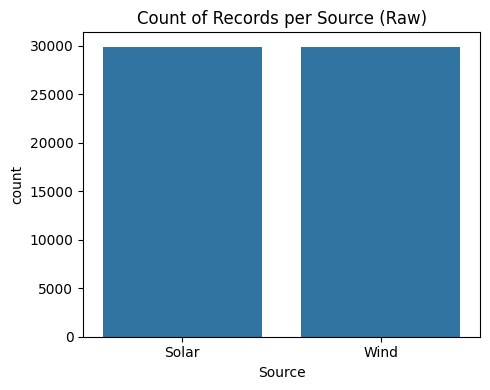

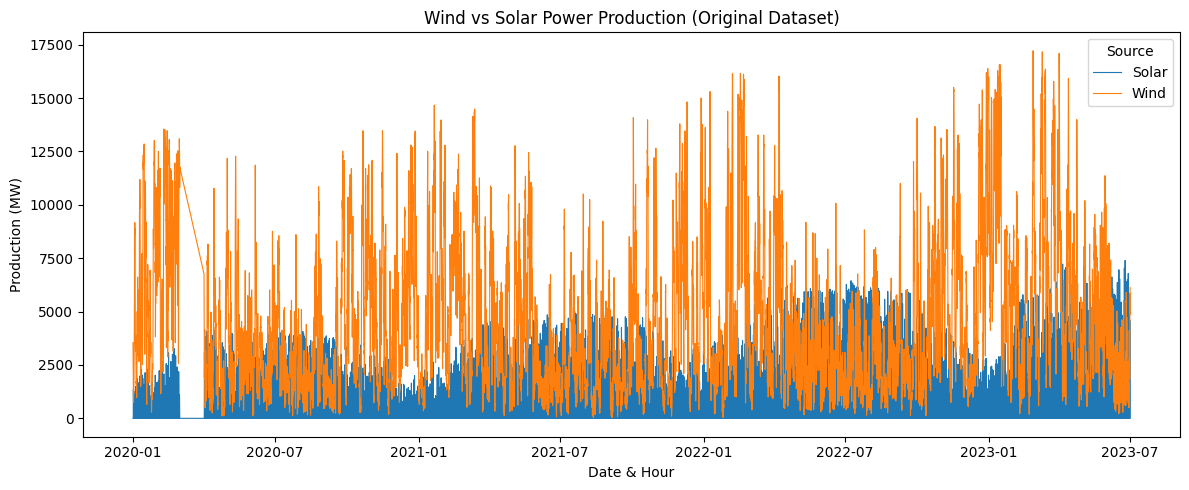

In [ ]:
# ================================
# 1. LOAD DATA + SIMPLE EDA
# ================================
df = pd.read_csv('wind_solar_data/intermittent-renewables-production-france.csv')
df.columns = df.columns.str.strip()

print("Raw columns:", df.columns.tolist())
print(df.head())

# Convert 'Date and Hour' to datetime for plotting
df['Date and Hour'] = pd.to_datetime(df['Date and Hour'], errors='coerce')

print("\nMissing values BEFORE clean-up:")
print(df.isna().sum())

# --- EDA 1: Source balance (fairness in dataset) ---
plt.figure(figsize=(5,4))
sns.countplot(x='Source', data=df)
plt.title('Count of Records per Source (Raw)')
plt.tight_layout()
plt.show()

# --- EDA 2: Raw production over time ---
plt.figure(figsize=(12,5))
sns.lineplot(x='Date and Hour', y='Production', hue='Source', data=df, linewidth=0.8)
plt.title('Wind vs Solar Power Production (Original Dataset)')
plt.xlabel('Date & Hour')
plt.ylabel('Production (MW)')
plt.legend(title='Source')
plt.tight_layout()
plt.show()


Shape BEFORE pivot/clean: (59804, 3)
Shape AFTER pivot + hourly resample: (30647, 2)
Source                     solar_prod  wind_prod
timestamp                                       
2019-12-31 23:00:00+00:00         0.0     3549.0
2020-01-01 00:00:00+00:00         0.0     2952.0
2020-01-01 01:00:00+00:00         0.0     2722.0
2020-01-01 02:00:00+00:00         0.0     2753.0
2020-01-01 03:00:00+00:00         0.0     2707.0


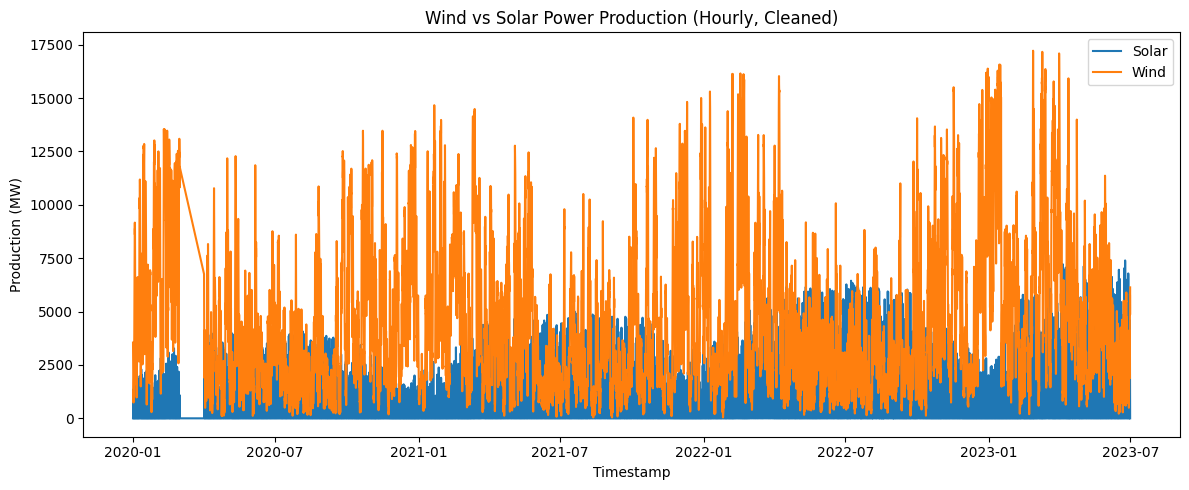


Data AFTER feature engineering:
Source                     solar_prod  wind_prod  hour  dayofyear  hour_sin  \
timestamp                                                                     
2019-12-31 23:00:00+00:00         0.0     3549.0    23        365 -0.258819   
2020-01-01 00:00:00+00:00         0.0     2952.0     0          1  0.000000   
2020-01-01 01:00:00+00:00         0.0     2722.0     1          1  0.258819   
2020-01-01 02:00:00+00:00         0.0     2753.0     2          1  0.500000   
2020-01-01 03:00:00+00:00         0.0     2707.0     3          1  0.707107   

Source                     hour_cos       doy_sin   doy_cos  
timestamp                                                    
2019-12-31 23:00:00+00:00  0.965926  6.432491e-16  1.000000  
2020-01-01 00:00:00+00:00  1.000000  1.721336e-02  0.999852  
2020-01-01 01:00:00+00:00  0.965926  1.721336e-02  0.999852  
2020-01-01 02:00:00+00:00  0.866025  1.721336e-02  0.999852  
2020-01-01 03:00:00+00:00  0.707107  1.72

In [ ]:
# ================================
# 2. DATA CLEAN-UP & FEATURE ENGINEERING
# ================================

# Create unified timestamp
df['timestamp'] = pd.to_datetime(df['Date and Hour'], errors='coerce', utc=True)

# Keep only needed columns & drop missing timestamps/production
df_clean = df[['timestamp', 'Source', 'Production']].dropna().copy()

print("\nShape BEFORE pivot/clean:", df_clean.shape)

# Pivot so we get one row per timestamp with both Wind & Solar columns
df_pivot = df_clean.pivot_table(values='Production', index='timestamp', columns='Source')
df_pivot = df_pivot.rename(columns={'Wind': 'wind_prod', 'Solar': 'solar_prod'})

# Sort by time and resample hourly (fill missing hours)
df_pivot = df_pivot.sort_index().resample('h').mean().interpolate()

print("Shape AFTER pivot + hourly resample:", df_pivot.shape)
print(df_pivot.head())

# --- EDA 3: After clean-up plot ---
plt.figure(figsize=(12,5))
plt.plot(df_pivot.index, df_pivot['solar_prod'], label='Solar')
plt.plot(df_pivot.index, df_pivot['wind_prod'], label='Wind')
plt.title('Wind vs Solar Power Production (Hourly, Cleaned)')
plt.xlabel('Timestamp')
plt.ylabel('Production (MW)')
plt.legend()
plt.tight_layout()
plt.show()

# Time-based features
df_pivot['hour'] = df_pivot.index.hour
df_pivot['dayofyear'] = df_pivot.index.dayofyear

# Cyclic encoding for hour/day-of-year
df_pivot['hour_sin'] = np.sin(2*np.pi*df_pivot['hour']/24)
df_pivot['hour_cos'] = np.cos(2*np.pi*df_pivot['hour']/24)
df_pivot['doy_sin'] = np.sin(2*np.pi*df_pivot['dayofyear']/365)
df_pivot['doy_cos'] = np.cos(2*np.pi*df_pivot['dayofyear']/365)

print("\nData AFTER feature engineering:")
print(df_pivot.head())


In [ ]:
# ================================
# 3. NORMALIZE DATA + CREATE SEQUENCES
# ================================
from sklearn.preprocessing import MinMaxScaler

features = ['wind_prod', 'solar_prod', 'hour_sin', 'hour_cos', 'doy_sin', 'doy_cos']
data = df_pivot[features].values.astype(np.float32)

# --- Proper normalization: fit scaler on TRAIN ONLY ---
n_total = len(data)
train_size_time = int(0.8 * n_total)

scaler = MinMaxScaler()
data_train_scaled = scaler.fit_transform(data[:train_size_time])
data_test_scaled  = scaler.transform(data[train_size_time:])
data_scaled = np.vstack([data_train_scaled, data_test_scaled])

seq_len = 48        # use past 48 hours
X, y = [], []
for i in range(len(data_scaled) - seq_len):
    X.append(data_scaled[i:i+seq_len])
    y.append(data_scaled[i+seq_len, :2])   # predict next-hour wind+solar

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

print("\nSequence shapes:")
print("X:", X.shape, "y:", y.shape)


Sequence shapes:
X: (30599, 48, 6) y: (30599, 2)


In [ ]:
# ================================
# 4. TRAIN / VAL / TEST SPLIT
# ================================
import torch
from torch.utils.data import TensorDataset, DataLoader

n_samples = len(X)
train_size = int(0.8 * n_samples)
val_size   = int(0.1 * train_size)   # 10% of train for validation

X_train_full, X_test = X[:train_size], X[train_size:]
y_train_full, y_test = y[:train_size], y[train_size:]

X_train, X_val = X_train_full[:-val_size], X_train_full[-val_size:]
y_train, y_val = y_train_full[:-val_size], y_train_full[-val_size:]

train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_ds   = TensorDataset(torch.from_numpy(X_val),   torch.from_numpy(y_val))
test_ds  = TensorDataset(torch.from_numpy(X_test),  torch.from_numpy(y_test))

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=64, shuffle=False)
test_dl  = DataLoader(test_ds, batch_size=64, shuffle=False)

print(f"\nTrain batches: {len(train_dl)}, Val batches: {len(val_dl)}, Test batches: {len(test_dl)}")



Train batches: 345, Val batches: 39, Test batches: 96


In [ ]:
# ================================
# 5. IMPROVED LSTM MODEL
# ================================
import torch.nn as nn

class MultiOutputLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])     # last time step
        return out                       # (batch, 2) → wind, solar

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultiOutputLSTM(
    input_size=len(features),
    hidden_size=64,
    num_layers=2,
    output_size=2,
    dropout=0.3
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Simple early stopping on validation loss
best_val_loss = np.inf
patience = 5
patience_counter = 0
n_epochs = 40

for epoch in range(1, n_epochs+1):
    # ---- Train ----
    model.train()
    train_losses = []
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # ---- Validation ----
    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss   = np.mean(val_losses)
    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    # Early stopping check
    if val_loss < best_val_loss - 1e-5:
        best_val_loss = val_loss
        best_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load best model
model.load_state_dict(best_state)

Epoch 01 | Train Loss: 0.012434 | Val Loss: 0.005206
Epoch 02 | Train Loss: 0.003120 | Val Loss: 0.003197
Epoch 03 | Train Loss: 0.001940 | Val Loss: 0.001655
Epoch 04 | Train Loss: 0.001406 | Val Loss: 0.001134
Epoch 05 | Train Loss: 0.001142 | Val Loss: 0.000943
Epoch 06 | Train Loss: 0.000917 | Val Loss: 0.000713
Epoch 07 | Train Loss: 0.000789 | Val Loss: 0.000517
Epoch 08 | Train Loss: 0.000696 | Val Loss: 0.000374
Epoch 09 | Train Loss: 0.000628 | Val Loss: 0.000509
Epoch 10 | Train Loss: 0.000556 | Val Loss: 0.000310
Epoch 11 | Train Loss: 0.000516 | Val Loss: 0.000328
Epoch 12 | Train Loss: 0.000479 | Val Loss: 0.000316
Epoch 13 | Train Loss: 0.000467 | Val Loss: 0.000306
Epoch 14 | Train Loss: 0.000447 | Val Loss: 0.000280
Epoch 15 | Train Loss: 0.000449 | Val Loss: 0.000259
Epoch 16 | Train Loss: 0.000421 | Val Loss: 0.000266
Epoch 17 | Train Loss: 0.000420 | Val Loss: 0.000231
Epoch 18 | Train Loss: 0.000396 | Val Loss: 0.000277
Epoch 19 | Train Loss: 0.000396 | Val Loss: 0.

<All keys matched successfully>


Performance metrics on TEST set:
Wind  - MAE: 245.21 MW, RMSE: 375.42 MW
Solar - MAE: 84.01 MW, RMSE: 154.90 MW


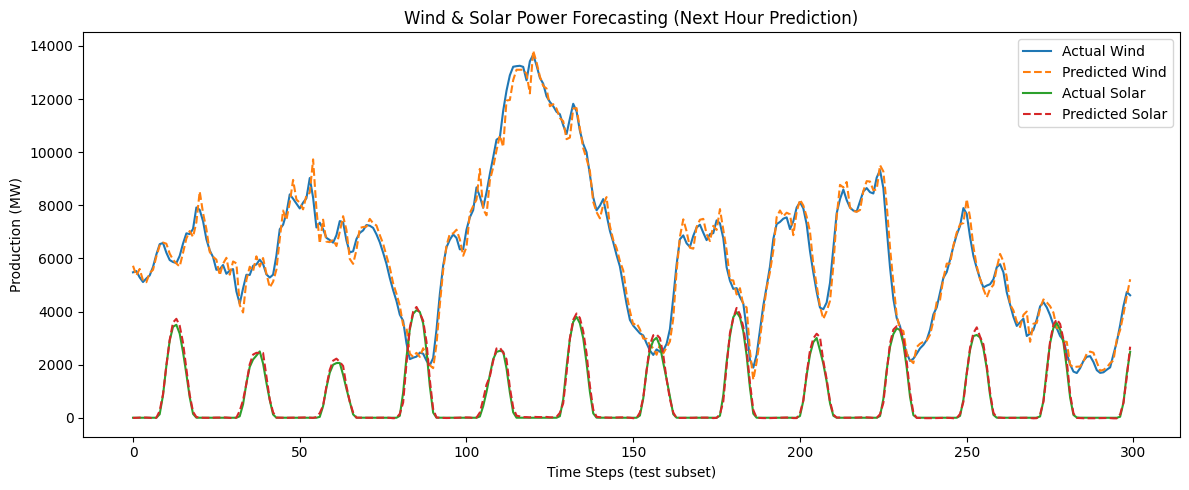

In [ ]:
# ================================
# 6. EVALUATION: PREDICTIONS + METRICS
# ================================
from sklearn.metrics import mean_absolute_error, mean_squared_error

model.eval()
preds, actuals = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        pred = model(xb).cpu().numpy()
        preds.append(pred)
        actuals.append(yb.numpy())

preds = np.vstack(preds)
actuals = np.vstack(actuals)

# Invert scaling (only for wind/solar columns)
def invert_scaling(two_col_array):
    # pad with zeros back to 6 features
    padded = np.hstack([two_col_array, np.zeros((len(two_col_array), 4))])
    inv = scaler.inverse_transform(padded)
    return inv[:, :2]

inv_preds   = invert_scaling(preds)
inv_actuals = invert_scaling(actuals)

# --- Simple metrics (per source → fairness) ---
wind_mae  = mean_absolute_error(inv_actuals[:,0], inv_preds[:,0])
solar_mae = mean_absolute_error(inv_actuals[:,1], inv_preds[:,1])

wind_rmse  = mean_squared_error(inv_actuals[:,0], inv_preds[:,0])
wind_rmse = np.sqrt(wind_rmse)

solar_rmse = mean_squared_error(inv_actuals[:,1], inv_preds[:,1])
solar_rmse = np.sqrt(solar_rmse)

print("\nPerformance metrics on TEST set:")
print(f"Wind  - MAE: {wind_mae:.2f} MW, RMSE: {wind_rmse:.2f} MW")
print(f"Solar - MAE: {solar_mae:.2f} MW, RMSE: {solar_rmse:.2f} MW")

# --- Plot sample of predictions ---
plt.figure(figsize=(12,5))
plt.plot(inv_actuals[:300,0], label='Actual Wind')
plt.plot(inv_preds[:300,0], label='Predicted Wind', linestyle='--')
plt.plot(inv_actuals[:300,1], label='Actual Solar')
plt.plot(inv_preds[:300,1], label='Predicted Solar', linestyle='--')
plt.title("Wind & Solar Power Forecasting (Next Hour Prediction)")
plt.xlabel("Time Steps (test subset)")
plt.ylabel("Production (MW)")
plt.legend()
plt.tight_layout()
plt.show()


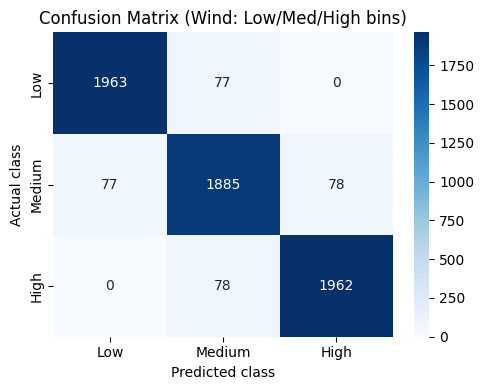

In [ ]:
# ================================
# 7. SIMPLE CONFUSION MATRIX (binned)
# ================================
from sklearn.metrics import confusion_matrix

def to_bins(values, n_bins=3):
    """Convert continuous values into 0,1,2 for Low/Med/High."""
    q1, q2 = np.quantile(values, [1/3, 2/3])
    return np.digitize(values, [q1, q2])  # 0,1,2

# Do this for WIND only (you can repeat for Solar similarly)
wind_true = inv_actuals[:,0]
wind_pred = inv_preds[:,0]

wind_true_bin = to_bins(wind_true)
wind_pred_bin = to_bins(wind_pred)

cm = confusion_matrix(wind_true_bin, wind_pred_bin)
labels = ['Low', 'Medium', 'High']

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Confusion Matrix (Wind: Low/Med/High bins)')
plt.tight_layout()
plt.show()